## Task 2: Create a Fraud Detection System
Develop a machine learning model to detect fraudulent transactions in financial
data.
Points: 50
Requirements:
1. Dataset Acquisition:
Obtain a dataset containing transactional data including features like transaction
amount, merchant information, and timestamps.
2. Data Preprocessing: (Optional - Brownie Points)
Preprocess the data by handling missing values, outlier detection, and feature
scaling.
3. Model Development:
Train a classification model (e.g., logistic regression, SVM, or neural networks) to
identify fraudulent transactions.
4. Evaluation:
Evaluate the model's performance using metrics such as precision, recall, F1 score,
and area under the ROC curve

In [116]:
import pandas as pd
import numpy as np

In [117]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
data = pd.read_csv('Frauds.csv')

In [120]:
print('Data does not have any NULL value.')
data.isnull().any()

Data does not have any NULL value.


step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [121]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [122]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

The provided data has the financial transaction data as well as the target variable **isFraud**, which is the actual fraud status of the transaction and **isFlaggedFraud** is the indicator which the simulation is used to flag the transaction using some **threshold value**.

In [123]:
print('Minimum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].min()

Minimum value of Amount, Old/New Balance of Origin/Destination:


amount            0.0
oldbalanceOrg     0.0
newbalanceOrg     0.0
oldbalanceDest    0.0
newbalanceDest    0.0
dtype: float64

In [124]:
print('Maximum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].max()

Maximum value of Amount, Old/New Balance of Origin/Destination:


amount            9.244552e+07
oldbalanceOrg     5.958504e+07
newbalanceOrg     4.958504e+07
oldbalanceDest    3.560159e+08
newbalanceDest    3.561793e+08
dtype: float64

## Data Analysis

----
Since there is **no missing** and **garbage value**, there is no need for data cleaning, but we still need to perform **data analysis** as data contaion huge variation of the value in different columns. Normalization will also imporve the overall accuracy of the machine learning model.

----

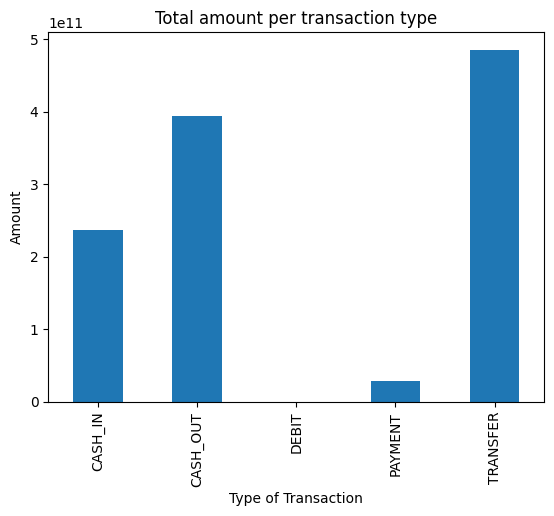

In [125]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount');

In [126]:
data.loc[data.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

The graph above shows that **TRANSFER** and **CASH_OUT** are two most used mode of transaction and we can see that **TRANSFER** and **CASH_OUT** are also the only way in which fraud happen. **Thus we will focus on this type of transactions**.

C:\Users\AtharvaShah\AppData\Local\Temp\ipykernel_28420\3894641840.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),cmap='RdBu');


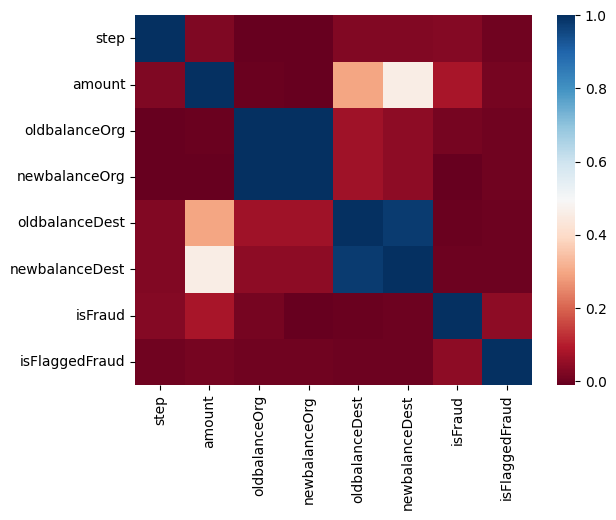

In [127]:
sns.heatmap(data.corr(),cmap='RdBu');

** Things we can conclude from this heatmap: **

* OldbalanceOrg and NewbalanceOrg are highly correlated.
* OldbalanceDest and NewbalanceDest are highly correlated.
* Amount is correlated with isFraud(Target Variable).

There is not much relation between the features, so we need to understand where the relationship between them depends on the type of transaction and amount. To do so, **we need to see the heat map of fraud and nonfraud transactions differently**.

In [128]:
fraud = data.loc[data.isFraud == 1]
nonfraud = data.loc[data.isFraud == 0]

In [129]:
fraudcount = fraud.isFraud.count()
nonfraudcount = nonfraud.isFraud.count()

C:\Users\AtharvaShah\AppData\Local\Temp\ipykernel_28420\2984347385.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fraud.corr(),cmap='RdBu',);


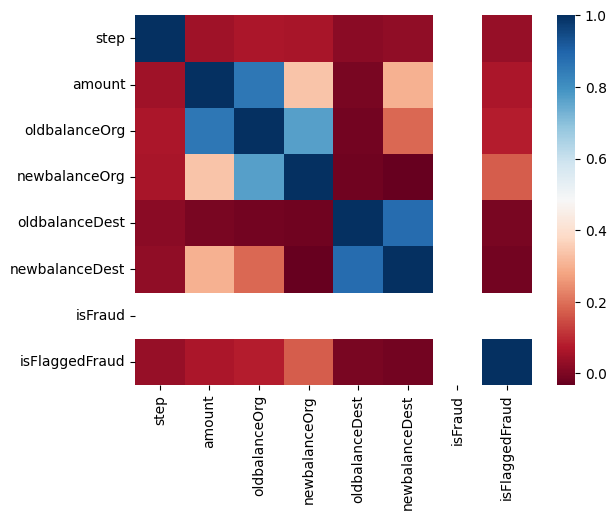

In [130]:
sns.heatmap(fraud.corr(),cmap='RdBu',);

There are 2 flags which stand out to me and it's interesting to look onto: isFraud and isFlaggedFraud column. From the hypothesis, **isFraud** is the indicator which indicates the **actual fraud transactions** whereas **isFlaggedFraud** is what the system prevents the transaction due to **some thresholds** being triggered. From the above heatmap we can see that there is some relation between other columns and isFlaggedFraud thus there must be relation between isFraud.

In [131]:
print('The total number of fraud transaction is {}.'.format(data.isFraud.sum()))
print('The total number of fraud transaction which is marked as fraud {}.'.format(data.isFlaggedFraud.sum()))
print('Ratio of fraud transaction vs non-fraud transaction is 1:{}.'.format(int(nonfraudcount//fraudcount)))

The total number of fraud transaction is 8213.
The total number of fraud transaction which is marked as fraud 16.
Ratio of fraud transaction vs non-fraud transaction is 1:773.


In [132]:
print('Thus in every 773 transaction there is 1 fraud transaction happening.')
print('Amount lost due to these fraud transaction is ${}.'.format(int(fraud.amount.sum())))

Thus in every 773 transaction there is 1 fraud transaction happening.
Amount lost due to these fraud transaction is $12056415427.


In [133]:
piedata = fraud.groupby(['isFlaggedFraud']).sum()

C:\Users\AtharvaShah\AppData\Local\Temp\ipykernel_28420\4146968039.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  piedata = fraud.groupby(['isFlaggedFraud']).sum()


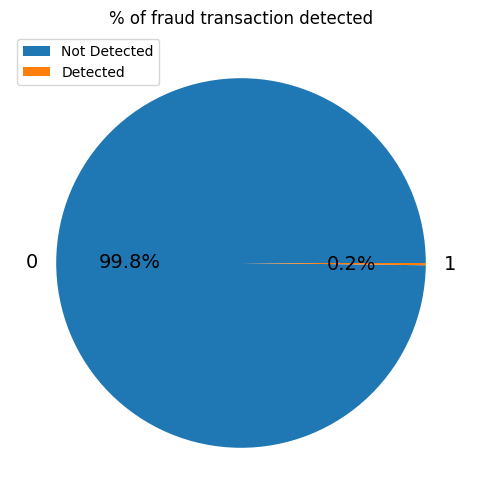

In [134]:
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

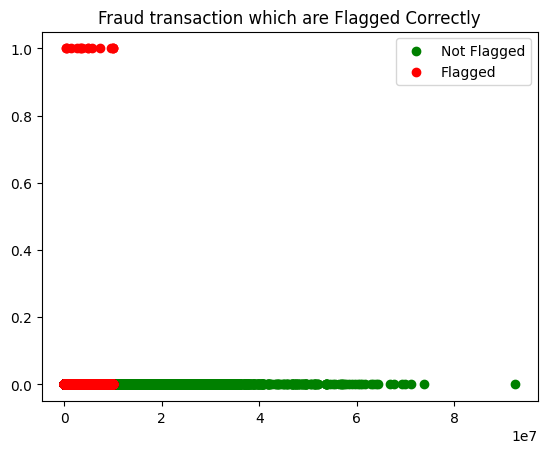

In [135]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.set_title("Fraud transaction which are Flagged Correctly")
axes.scatter(nonfraud['amount'],nonfraud['isFlaggedFraud'],c='g')
axes.scatter(fraud['amount'],fraud['isFlaggedFraud'],c='r')
plt.legend(loc='upper right',labels=['Not Flagged','Flagged'])
plt.show()

The plot above clearly shows the **need** for a system which can be **fast** and **reliable** to mark the transaction which is fraud. Since, the current system is letting fraud transaction able to **pass through a system** which is **not labeling them as a fraud**. Some data exploration can be helpful to check for the relation between features.

## Data Exploration


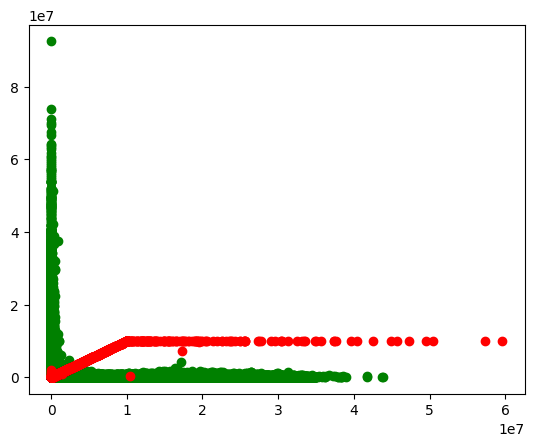

In [136]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(nonfraud['oldbalanceOrg'],nonfraud['amount'],c='g')
ax.scatter(fraud['oldbalanceOrg'],fraud['amount'],c='r')
plt.show()

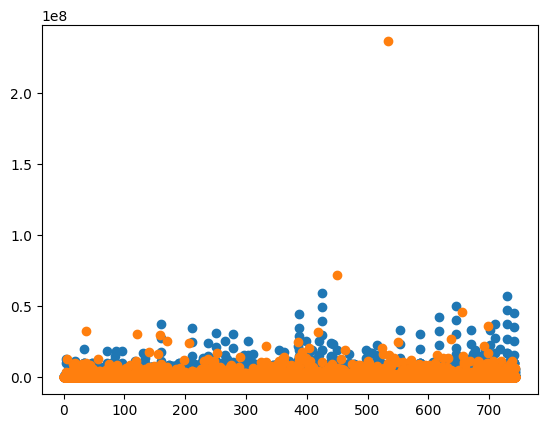

In [137]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

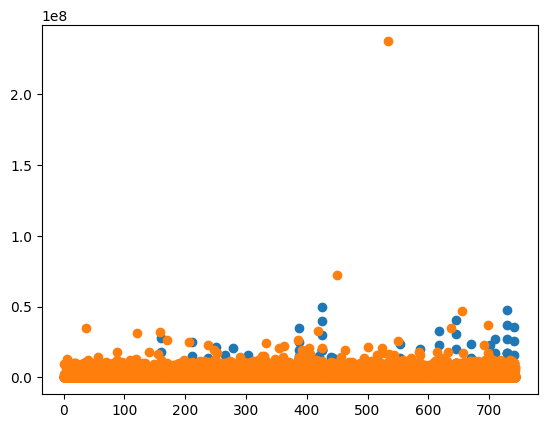

In [138]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['newbalanceOrg'])
ax.scatter(fraud['step'],fraud['newbalanceDest'])
plt.show()

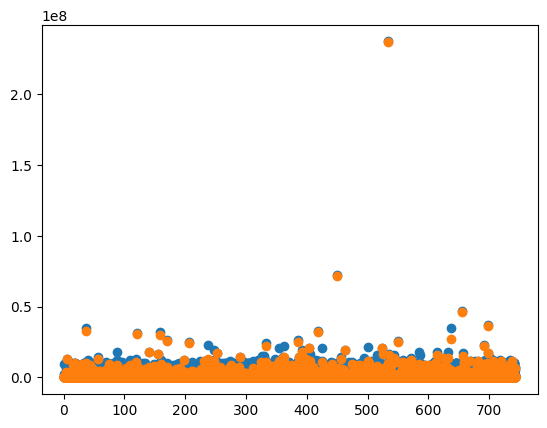

In [139]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['newbalanceDest'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

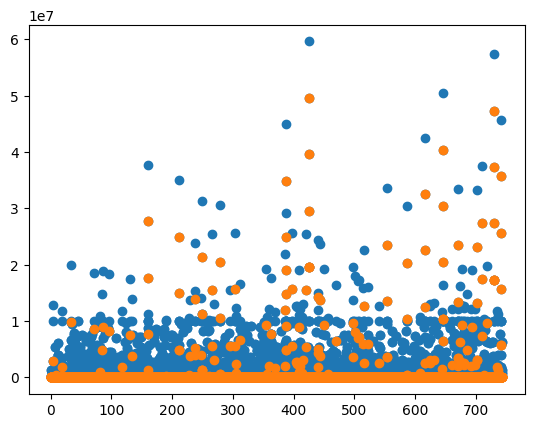

In [140]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['newbalanceOrg'])
plt.show()

## Data Cleaning

In [141]:
import pandas as pd
import numpy as np
import pickle

In [142]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [143]:
data_fraud = pd.read_csv('frauds.csv')

In [144]:
data_fraud = data_fraud.replace(to_replace={'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,
                                            'CASH_IN':4,'DEBIT':5,'No':0,'Yes':1})

In [145]:
data_fraud.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [146]:
data_fraud.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,2,181.00,181.0,0.00,0.0,0.0,1
3,1,3,181.00,181.0,0.00,21182.0,0.0,1
4,1,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [147]:
X = data_fraud.drop(['isFraud'],axis=1)
y = data_fraud[['isFraud']]

## Machine Learning Model

In [148]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 121)

In [149]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=15)

In [150]:
# probabilities = clf.fit(train_X, train_y.values.ravel()).predict(test_X)

: 

In [ ]:
from sklearn.metrics import average_precision_score
print(average_precision_score(test_y,probabilities))

**Average precision score is 0.7687.**

In [ ]:
# 4. Evaluation:
# Evaluate the model's performance using metrics such as precision, recall, F1 score,
# and area under the ROC curve

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# calculate precision
precision = precision_score(test_y, probabilities)

# calculate recall
recall = recall_score(test_y, probabilities)

# calculate f1-score
f1 = f1_score(test_y, probabilities)

# area under the roc curve
roc_auc = roc_auc_score(test_y, probabilities)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1: {}'.format(f1))
print('roc_auc: {}'.format(roc_auc))



In [ ]:
# print the roc curve graph

fpr, tpr, thresholds = roc_curve(test_y, probabilities)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()